# PA 7-2: Penalized Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt

In [2]:
ames = pd.read_csv("https://raw.githubusercontent.com/kevindavisross/data301/main/data/AmesHousing.txt", sep="\t")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,189900


## 14.1: Setup and Check-In Questions

In [3]:
X = ames.drop(["SalePrice", "Order", "PID"], axis=1)
y = ames["SalePrice"]

ct = ColumnTransformer(
    [
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize",
         StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)

**Check-In Question 1:** What did `handle_unknown='ignore'` accomplish?

It tells OneHotEncoder to ignore categories in test/validation data that weren't in training data, preventing errors during cross-validation when new categories appear.

**Check-In Question 2:** What did `make_column_selector(dtype_include=object)` accomplish?

It selects all object (categorical) columns for one-hot encoding, making the pipeline flexible and less error-prone than manually listing column names.

**Check-In Question 3:** Why did we drop the `Order` and `PID` columns?

They are identifiers with no predictive relationship to house prices. Including them would add noise and potentially cause overfitting.

In [4]:
ols_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='r2')
print("OLS CV R-squared scores:", ols_scores)
print(f"Mean: {ols_scores.mean():.4f}")

OLS CV R-squared scores: [0.89727873 0.91038253 0.78900365 0.77208628 0.9006982 ]
Mean: 0.8539


In [5]:
lr_pipeline.fit(X, y)
ols_coefs = lr_pipeline.named_steps['linear_regression'].coef_

## 14.2: Ridge Regression with λ = 1

In [6]:
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge", Ridge(alpha=1))]
)

ridge_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='r2')
print("Ridge CV R-squared scores:", ridge_scores)
print(f"Mean: {ridge_scores.mean():.4f}")
print(f"\nOLS Mean: {ols_scores.mean():.4f}")
print(f"Ridge Mean: {ridge_scores.mean():.4f}")

Ridge CV R-squared scores: [0.89815807 0.91744024 0.79493606 0.78522563 0.91389818]
Mean: 0.8619

OLS Mean: 0.8539
Ridge Mean: 0.8619


<Axes: xlabel='ols', ylabel='ridge'>

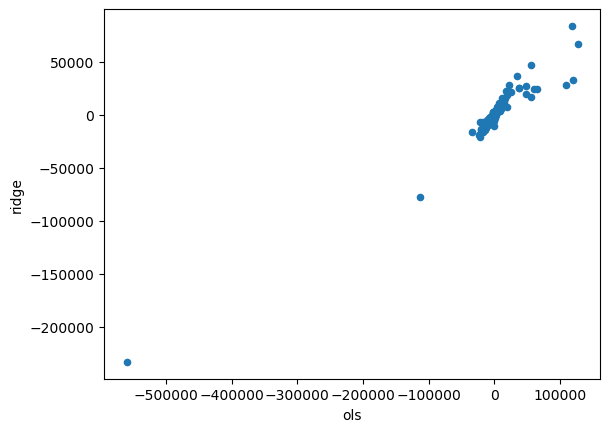

In [7]:
ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps['ridge'].coef_

coef_compare = pd.DataFrame()
coef_compare["ols"] = ols_coefs
coef_compare["ridge"] = ridge_coefs

coef_compare.plot.scatter(x='ols', y='ridge')

## 14.2.1: Tuning λ for Ridge

In [8]:
ridge_tune = Pipeline(
    [("preprocessing", ct),
     ("ridge", Ridge())]
)

param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_tune, param_grid, cv=5, scoring='r2')
ridge_grid.fit(X, y)

print(f"Best λ: {ridge_grid.best_params_['ridge__alpha']}")
print(f"Best CV R-squared: {ridge_grid.best_score_:.4f}")

Best λ: 10
Best CV R-squared: 0.8643


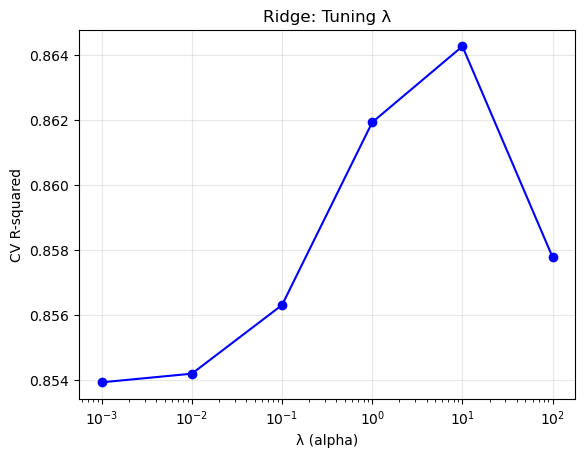

In [9]:
results = pd.DataFrame(ridge_grid.cv_results_)
plt.semilogx(results['param_ridge__alpha'], results['mean_test_score'], 'bo-')
plt.xlabel('λ (alpha)')
plt.ylabel('CV R-squared')
plt.title('Ridge: Tuning λ')
plt.grid(True, alpha=0.3)
plt.show()

## 14.3.1: LASSO Regression

In [10]:
lasso_tune = Pipeline(
    [("preprocessing", ct),
     ("lasso", Lasso())]
)

param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso_tune, param_grid, cv=5, scoring='r2')
lasso_grid.fit(X, y)

print(f"Best λ: {lasso_grid.best_params_['lasso__alpha']}")
print(f"Best CV R-squared: {lasso_grid.best_score_:.4f}")

C:\Users\shawh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\shawh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\shawh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e+11, toleranc

Best λ: 100
Best CV R-squared: 0.8669


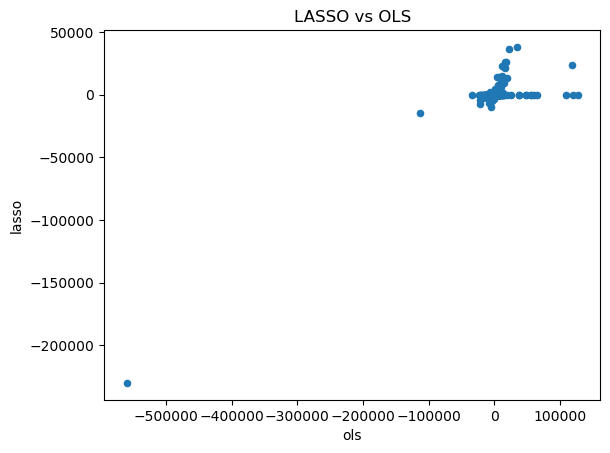

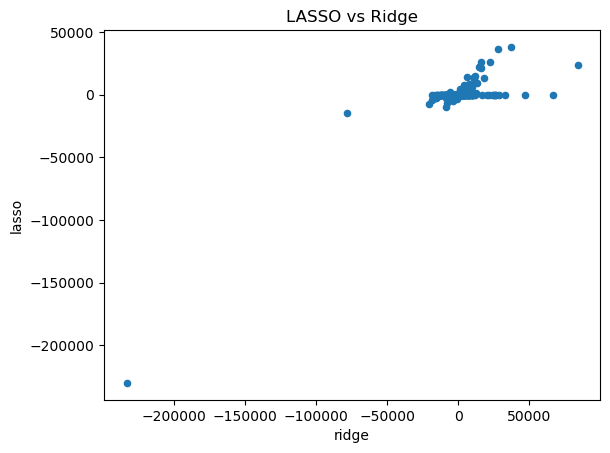

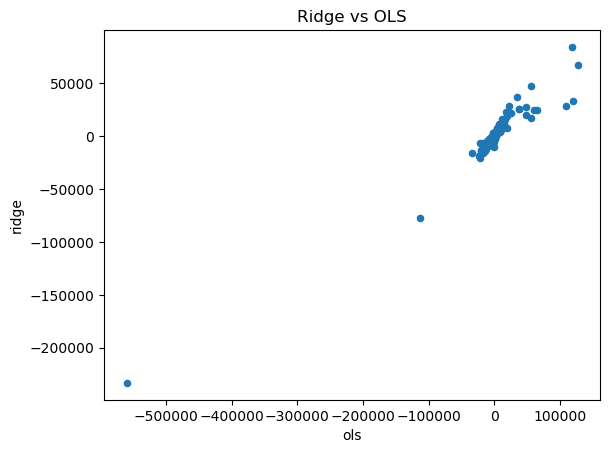

In [11]:
lasso_coefs = lasso_grid.best_estimator_.named_steps['lasso'].coef_
ridge_best_coefs = ridge_grid.best_estimator_.named_steps['ridge'].coef_

coef_compare["lasso"] = lasso_coefs

# Compare LASSO vs OLS
coef_compare.plot.scatter(x='ols', y='lasso', title='LASSO vs OLS')
plt.show()

# Compare LASSO vs Ridge
coef_compare.plot.scatter(x='ridge', y='lasso', title='LASSO vs Ridge')
plt.show()

# Compare Ridge vs OLS
coef_compare.plot.scatter(x='ols', y='ridge', title='Ridge vs OLS')
plt.show()

## 14.3.3: Elastic Net

In [12]:
elastic_tune = Pipeline(
    [("preprocessing", ct),
     ("elastic", ElasticNet())]
)

param_grid = {
    'elastic__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'elastic__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
}
elastic_grid = GridSearchCV(elastic_tune, param_grid, cv=5, scoring='r2')
elastic_grid.fit(X, y)

print(f"Best λ: {elastic_grid.best_params_['elastic__alpha']}")
print(f"Best α (l1_ratio): {elastic_grid.best_params_['elastic__l1_ratio']}")
print(f"Best CV R-squared: {elastic_grid.best_score_:.4f}")

C:\Users\shawh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.517e+11, tolerance: 1.348e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\shawh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.311e+11, tolerance: 1.474e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV 

Best λ: 100
Best α (l1_ratio): 1.0
Best CV R-squared: 0.8669


In [13]:
elastic_coefs = elastic_grid.best_estimator_.named_steps['elastic'].coef_

print("\nFinal Comparison:")
print(f"{'Model':<25} {'CV R-squared':<15} {'Zero Coefs':<10}")
print("="*50)
print(f"{'OLS':<25} {ols_scores.mean():<15.4f} {(ols_coefs == 0).sum():<10}")
print(f"{'Ridge (best)':<25} {ridge_grid.best_score_:<15.4f} {(ridge_best_coefs == 0).sum():<10}")
print(f"{'LASSO (best)':<25} {lasso_grid.best_score_:<15.4f} {(lasso_coefs == 0).sum():<10}")
print(f"{'Elastic Net (best)':<25} {elastic_grid.best_score_:<15.4f} {(elastic_coefs == 0).sum():<10}")


Final Comparison:
Model                     CV R-squared    Zero Coefs
OLS                       0.8539          0         
Ridge (best)              0.8643          0         
LASSO (best)              0.8669          163       
Elastic Net (best)        0.8669          163       
